In [1]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data_dir = "datasets\simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('\\')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)

print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")

Изображений в train: 14653
Изображений в val: 6280


In [4]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.RandomRotation(20),
    transforms.TrivialAugmentWide(),
    transforms.AugMix(),
    transforms.RandomVerticalFlip(p=0.5),
    
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [5]:
print("Количество классов в train:", len(train_dataset.classes))
print("Количество классов в val:", len(val_dataset.classes))
print("Количество классов одинаково:", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train: 42
Количество классов в val: 42
Количество классов одинаково: True


In [6]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

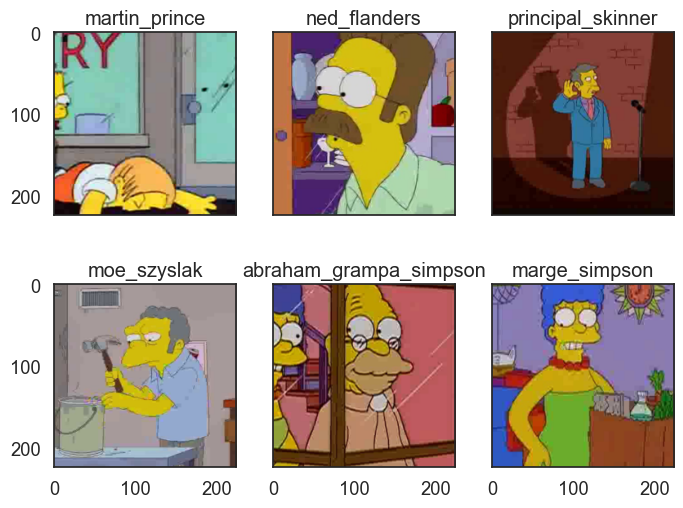

In [7]:
show_images(val_dataset)

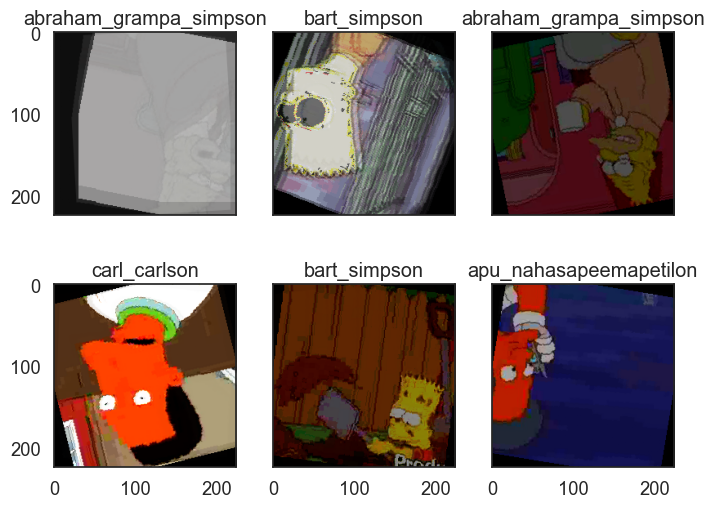

In [8]:
show_images(train_dataset)

In [9]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [10]:
def train(model, criterion, optimizer, train_batch_gen, val_batch_gen, scheduler=None, num_epochs=10):

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc, start_time  = 0, 0, 0, 0, time.time()

        model.train(True) 

        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        if scheduler: scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [11]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [12]:
from torchvision.models import resnet18

Epoch 10 of 10 took 280.118s
  training loss (in-iteration): 	2.561635
  validation loss (in-iteration): 	2.239120
  training accuracy: 			28.47 %
  validation accuracy: 			36.90 %


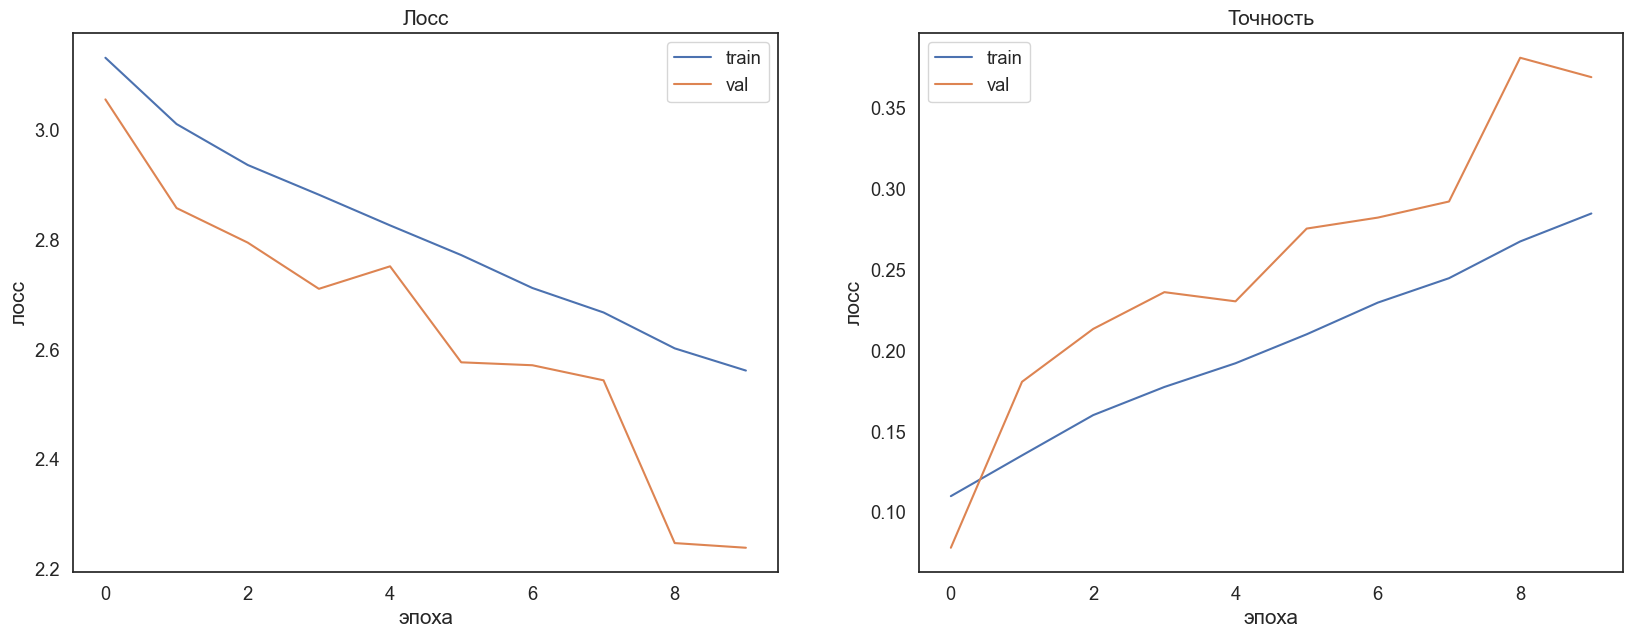

In [21]:
model = resnet18(weights=None)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Подобраны аугментации train данных, при которых итоговое качество на валидации столо сильно хуже, чем полученное на занятии.

## torch.optim.lr_scheduler.StepLR

уберем часть аугментаций, понижающих метрики

In [13]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.RandomAffine(5),
    transforms.RandomRotation(20),
    transforms.RandomVerticalFlip(p=0.5),
    
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

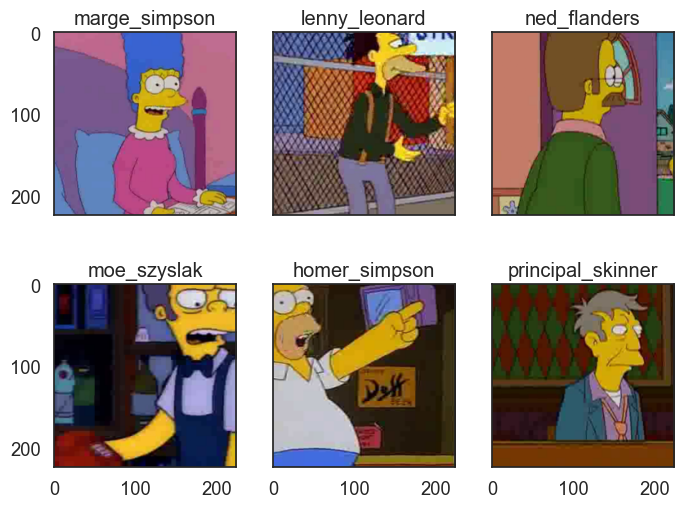

In [14]:
show_images(val_dataset)

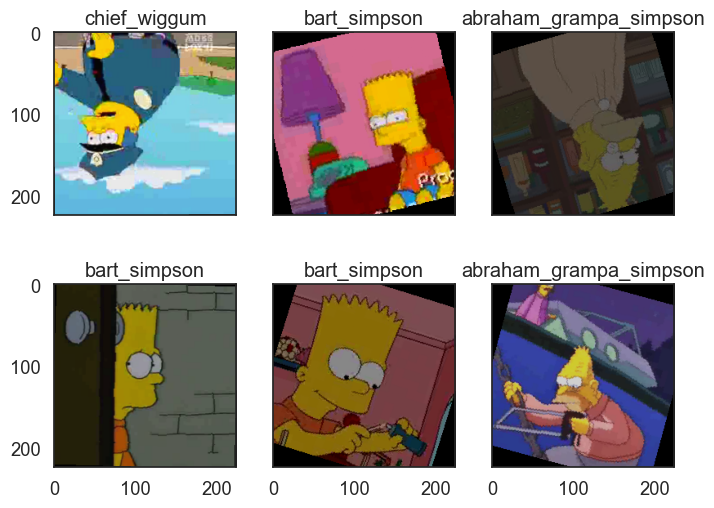

In [15]:
show_images(train_dataset)

добавим скедулер StepLR

Epoch 10 of 10 took 247.372s
  training loss (in-iteration): 	2.571443
  validation loss (in-iteration): 	2.185892
  training accuracy: 			27.87 %
  validation accuracy: 			39.96 %


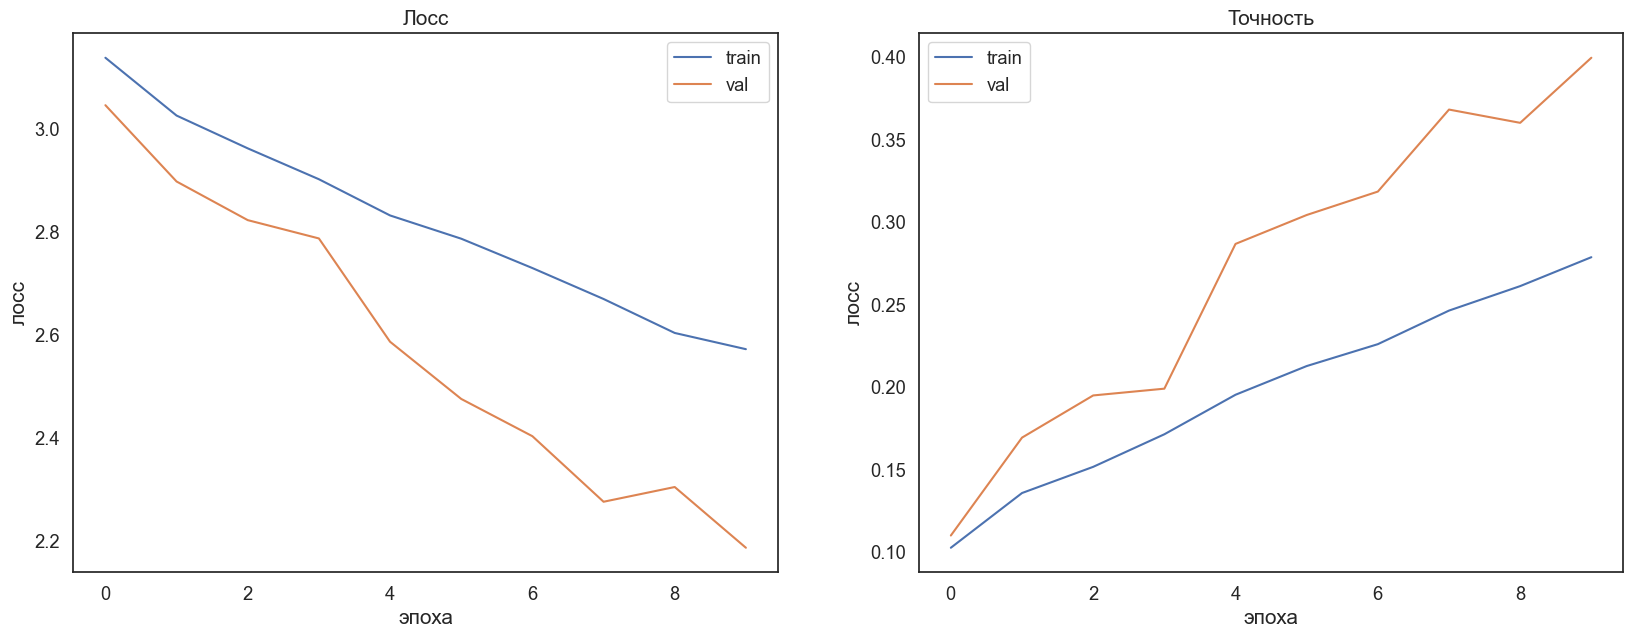

In [34]:
model_steplr = resnet18(weights=None)
model_steplr.fc = nn.Linear(512, 42)
model_steplr = model_steplr.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_steplr.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

clf_model, history = train(
    model_steplr, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

## torch.optim.lr_scheduler.LinearLR

заменим скедулер на LinearLR

Epoch 10 of 10 took 285.978s
  training loss (in-iteration): 	2.558072
  validation loss (in-iteration): 	2.128070
  training accuracy: 			28.25 %
  validation accuracy: 			41.98 %


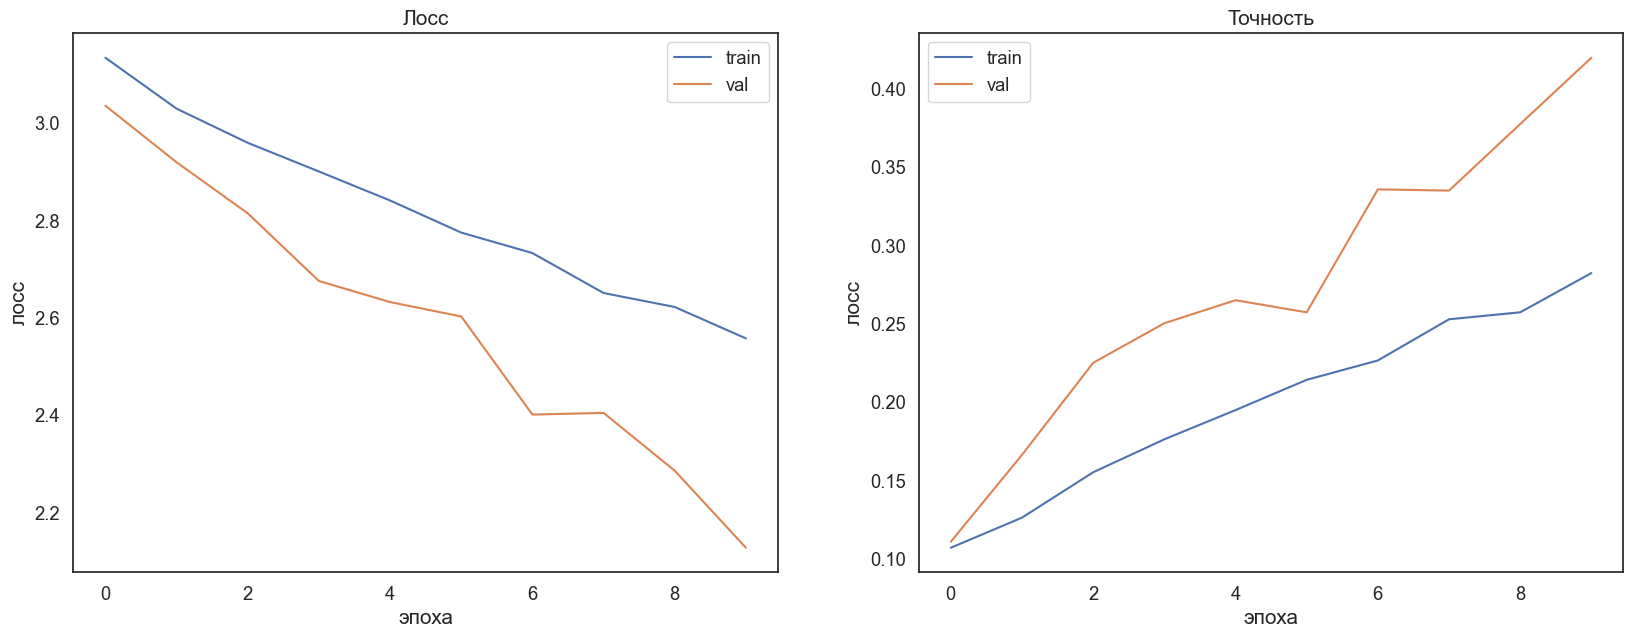

In [38]:
model_steplr = resnet18(weights=None)
model_steplr.fc = nn.Linear(512, 42)
model_steplr = model_steplr.to(device)
num_epochs=10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_steplr.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=num_epochs)

clf_model, history = train(
    model_steplr, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=num_epochs
)

## FineTuning модели MOBILENET V2

In [21]:
from torchvision.models import mobilenet_v2
from torchvision.models import MobileNet_V2_Weights

In [22]:
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('mobilenet', mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:01<00:00, 11.7MB/s]


In [23]:
print(fine_tuning_model)

Sequential(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(

In [24]:
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

Epoch 10 of 10 took 954.903s
  training loss (in-iteration): 	0.762664
  validation loss (in-iteration): 	0.419527
  training accuracy: 			79.79 %
  validation accuracy: 			89.06 %


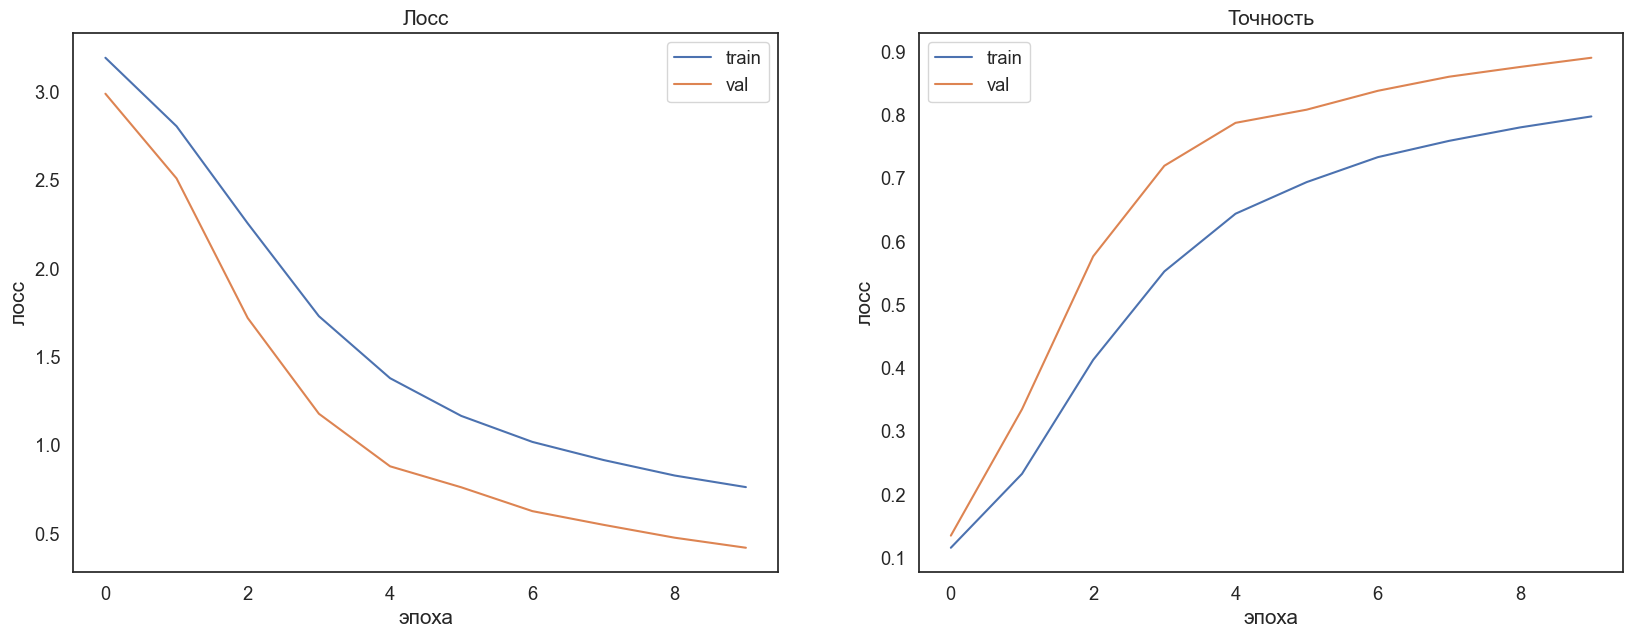

In [26]:
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=num_epochs)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=num_epochs
)

Выводы:
В ходе работы были подобраны аугментации train данных, при которых итоговое качество на валидации значительно ухудшилось (на 20%) по сравнению с полученным на занятии.
Аугментации transforms.TrivialAugmentWide() и transforms.AugMix()
значительно изменяют изображение, за счет чего модели сложнее правильно классифицировать изображения.
Применяются на обучающей выборке.

Далее были добавлены регуляторы изменения скорости обучения lr_scheduler.StepLR и lr_scheduler.LinearLR.
Были сравнены две непредобученные модели resnet18 с данными регуляторами. 
Лучшую метрику показал LinearLR, однако, стоит учитывать возможность регулирования гиперпараметров скедулеров и ограничение 10 эпохами обучения.

Далее был выполнен fine tuning модели MobileNetV2. Были добавлены 2 линейных слоя для классификации на 42 класса.
Благодаря хорошим стартовым весам MobileNet_V2_Weights.DEFAULT, сеть обучалась довольно быстро. Уже ко второй эпохе точность на валидации составляла 50%.
Далее график точности монотонно увеличивался, стремясь к значениям приблизительно 0.9 - 1.0